**Задание Проекта**
  
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<div style="border:solid gray 2px; padding: 20px">  

**Целевой признак**

Нужно спрогнозировать сразу две величины:  
    
- эффективность обогащения чернового концентрата **rougher.output.recovery**;
- эффективность обогащения финального концентрата **final.output.recovery**.

**В данном проекте:**  
  
  Предсказываем показатели, которые вычисляются только после того, как выполнены все стадии обработки золотосодержащей руды. Машинное обучение в этом проекте помогает определиться в целесообразности добычи и обработки руды.

---

## Подготовка данных

### Импорт библиотек. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


RANDOM = 12345

In [2]:
# Загрузка данных

df_list = []

pth1 = '/Users/macbookair13i5/Desktop/datasets/Datasets/Second_Combine_project/gold_recovery_train_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv'

if os.path.exists(pth1):
    df_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_train = pd.read_csv(pth2)
else:
    display('Something is wrong')

pth3 = '/Users/macbookair13i5/Desktop/datasets/Datasets/Second_Combine_project/gold_recovery_test_new.csv' 
pth4 = 'https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv'

if os.path.exists(pth3):
    df_test = pd.read_csv(pth3)
elif os.path.exists(pth4):
    df_test = pd.read_csv(pth4)
else:
    display('Something is wrong')


pth5 = '/Users/macbookair13i5/Desktop/datasets/Datasets/Second_Combine_project/gold_recovery_full_new.csv'
pth6 = 'https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv'

if os.path.exists(pth5):
    df_full = pd.read_csv(pth5)
elif os.path.exists(pth6):
    df_full = pd.read_csv(pth6)
else:
    display('Something is wrong')

### Описание данных

**Технологический процесс**  


|Название| Описание данных|
|:|:|
|**rougher feed**| Исходное сырье|
|**gher additions (или reagent additions)**| флотационные реагенты: Xanthate, Sulphate, Depressant|
|**Xanthate**| Ксантогенат (промотер, или активатор флотации)|
|**Sulphate**| Cульфат (на данном производстве сульфид натрия)|
|**Depressant**| Депрессант (силикат натрия)|
|**Rougher process**| (англ. «грубый процесс») — флотация|
|**Rougher tails**| Отвальные хвосты|
|**Float banks**| Флотационная установка|
|**Cleaner process**|Очистка|
|**Rougher Au**|Черновой концентрат золота|
|**Final Au**|Финальный концентрат золота|

**Параметры этапов**  


|Параметры этапов| Описание данных|  
|:|:|  
|**air amount**| Объём воздуха|
|**fluid levels**| Уровень жидкости|
|**feed size**| Размер гранул сырья|
|**feed rate**| Скорость подачи|


**Наименование признаков**  

|Этап| Описание данных|  
|:|:|  
|**input**| параметры сырья|
|**output**| параметры продукта|
|**state**| параметры, характеризующие текущее состояние этапа|
|**calculation**| расчётные характеристики|




### Проверка рассчетов эффективности обогащения

Из описания проекта добавим формулу рассчета обогащения

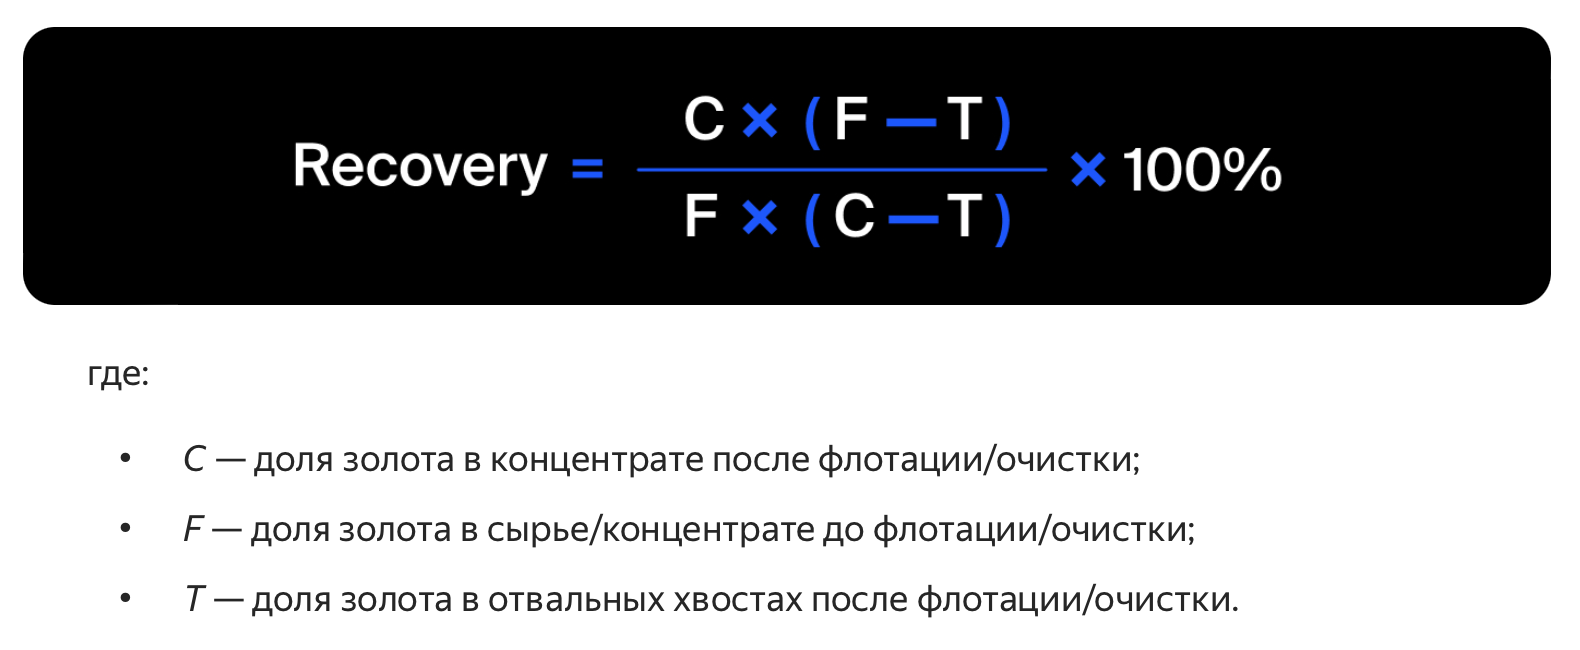

In [3]:
# Рассчитаем Эффективность Обогащения.

C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# Для наглядного отображения создадим доп. столбец (Позднее его удалим)
df_train['Recovery'] = pd.Series(C * (F-T)*100 / (F * (C-T)))

In [4]:
# Проверим правильно ли рассчитана эффективность обогащения в данных

display(df_train[['rougher.output.recovery', 'Recovery']].head())

,rougher.output.recovery,Recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [5]:
# Посчитаем MAE полученной эффективности и существующих показателей

MAE_recovery = mean_absolute_error(df_train['rougher.output.recovery'], df_train['Recovery'])
print(f'MAE: {MAE_recovery}')

MAE: 1.1131451184435918e-14


Показатель MAE - очень низкий - это говорит о том что показатель эффективности обогащения рассчитанный по формуле практически совпадает со значениями указанными в наборе данных (т.е. посчитан по формуле верно)

**Recovery рассчитано верно**

In [6]:
# Удалим дублирующийся столбец 

df_train = df_train.drop(['Recovery'], axis = 1)

In [7]:
df_list.extend([df_train, df_test, df_full])

### Наличие и отсутствие признаков в обучающей и тестовой выборках

In [8]:
common_columns = []
full_columns = []
for col in df_train.columns:
    if col in df_test.columns:
        common_columns.append(col)
    elif col not in df_test.columns:
        full_columns.append(col)
print(f'Количество признаков в полном наборе {len(df_full.columns)}')
print('-'*25)
print(f'Количество признаков в обучающей выборке {len(df_train.columns)}')
print(f'Количество признаков в тестовой выборке {len(df_test.columns)}')
print(f'Количество общих признаков {len(common_columns)}')
print(f'Количество признаков, которыx нет в тестовом наборе: {len(full_columns)}')
print('-'*25)
print()
print(f'Признаки, которых нет в тестовом наборе:')
print()
for col in full_columns:
    print(col)
    

Количество признаков в полном наборе 87
-------------------------
Количество признаков в обучающей выборке 87
Количество признаков в тестовой выборке 53
Количество общих признаков 53
Количество признаков, которыx нет в тестовом наборе: 34
-------------------------

Признаки, которых нет в тестовом наборе:

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output

Из наименований признаков и описания проекта очевидно, что в тестовый набор не попали следующие показатели признаков :  

В тестовый набор не входит тип параметра  

  **output** - это значения полученных продуктов (на выходе) на определенном этапе обработки!  
    
- rougher - флотация
- primary_cleaner - после первичной очистки  
- secondary_cleaner - после вторичной очистки  
- final - финальные характеристики  
- calculation - расчётные характеристики  
  
  Также исвестно, что в тестовом наборе нет **целевых признаков**
- rougher.output.recovery;
- final.output.recovery.

### Предобработка данных

#### Корреляция признаков

Проверим взаимосвязь признаков, если будут взаимозаменяемые - можно удалить

In [9]:
for df in df_list:
    pd.set_option('display.max_columns', None)
    display(df.corr().head(1))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.0,0.02111,0.351985,-0.104934,0.133238,0.289552,-0.099818,0.045896,0.193935,0.015923,0.136008,0.024921,0.165403,0.502774,-0.176998,0.31581,-0.185916,-0.001483,-0.062081,0.165046,0.191298,0.188219,0.041814,0.203256,0.053429,0.16576,0.043158,0.09807,0.007139,-0.016921,-0.027763,-0.037668,0.195373,0.424378,0.004272,-0.177363,-0.021952,-0.045802,0.276645,-0.115623,0.069868,-0.140668,0.087768,0.288717,-0.167535,-0.042561,0.033109,0.037976,0.191569,-0.032464,0.023109,0.131941,0.115834,-0.188839,0.119946,0.083973,0.099507,0.087969,0.129379,0.08358,0.187447,0.100778,0.153916,0.097132,-0.080417,-0.309225,0.142095,0.04437,-0.061512,0.036827,-0.025608,0.03936,0.054267,0.1807,0.027815,0.208832,0.041765,0.169538,0.020832,0.005319,0.013019,0.228753,0.02166,0.199048,0.170298,0.061009


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.0,0.455718,0.114456,0.497568,0.102653,0.048032,0.075737,0.138949,0.02471,0.027697,0.095001,-0.020533,0.359619,0.428382,0.464251,-0.009796,0.423859,0.437016,0.617768,0.557307,0.583022,0.527014,0.236898,0.222913,-0.23067,-0.047665,-0.247043,-0.051896,-0.247163,-0.016032,-0.234958,-0.120379,-0.250187,-0.063497,0.051989,-0.039145,0.254702,-0.011921,0.136986,0.003869,0.148037,0.020303,0.305793,0.117976,0.348395,0.068693,0.093608,0.132193,0.156583,0.072618,-0.134499,0.033945


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.0,0.06357,0.380142,-0.038373,0.185952,0.334596,-0.051855,0.02889,0.206569,0.071158,0.127827,0.040543,0.127175,0.509877,-0.152814,0.332771,-0.200367,0.043138,-0.023182,0.175824,0.163903,0.175978,0.039789,0.194615,0.058284,0.15436,0.036542,0.11036,-0.001388,-0.01419,-0.034702,-0.03913,0.158668,0.456279,0.074866,-0.167154,-0.043895,-0.036783,0.315817,-0.096561,0.093678,-0.113477,0.114032,0.315558,-0.127291,-0.018497,0.044347,0.084148,0.204522,-0.049453,0.008952,0.125401,0.102807,-0.206426,0.086768,0.09465,0.079634,0.099465,0.094354,0.094249,0.135264,0.104504,0.091003,0.097289,-0.039046,-0.286238,0.157687,0.048926,-0.058101,0.024641,-0.016135,0.024709,0.061833,0.116037,0.06568,0.138392,0.027343,0.104118,0.029887,-0.063246,-0.004246,0.184332,0.003693,0.156471,0.162591,0.059581


Взаимозаменяемых столбцов нет

#### Проверка формата данных

In [10]:
list_of_frame = ['Обучающая выборка', 'Тестовая выборка', 'Полная выборка']

for num, df in enumerate(df_list):
    print()
    print(list_of_frame[num])
    print(df.dtypes)


Обучающая выборка
date                                           object
final.output.concentrate_ag                   float64
final.output.concentrate_pb                   float64
final.output.concentrate_sol                  float64
final.output.concentrate_au                   float64
                                               ...   
secondary_cleaner.state.floatbank5_a_level    float64
secondary_cleaner.state.floatbank5_b_air      float64
secondary_cleaner.state.floatbank5_b_level    float64
secondary_cleaner.state.floatbank6_a_air      float64
secondary_cleaner.state.floatbank6_a_level    float64
Length: 87, dtype: object

Тестовая выборка
date                                           object
primary_cleaner.input.sulfate                 float64
primary_cleaner.input.depressant              float64
primary_cleaner.input.feed_size               float64
primary_cleaner.input.xanthate                float64
primary_cleaner.state.floatbank8_a_air        float64
primary_cleaner.sta

Столбцы с датой переведем в формат Datetime

In [11]:
for df in df_list:
    df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')

#### Проверка пропусков

Отдельно проверим пропуски в столбцах с датой.

In [12]:
for df in df_list:
    display('Пропусков:', df['date'].isna().sum())

'Пропусков:'

0

'Пропусков:'

0

'Пропусков:'

0

Изучим количество пропусков в каждой выборке!

In [13]:
for num, df in enumerate(df_list):
    print()
    print('Пропуски')
    print(f'{list_of_frame[num]}:')
    print()
    print(df.isna().sum().sort_values(ascending=False).head(10))
    print('-'*25)


Пропуски
Обучающая выборка:

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
dtype: int64
-------------------------

Пропуски
Тестовая выборка:

rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.xanthate               4
primary_cleaner.input.sulfate                4
rougher.input.feed_rate             

Пропусков много в полной и обучающей выборках! Нам важно сохранить данные! Поэтому заменим пропуски на определенные значения.  
Буду использовать .fillna(method = 'ffill'/'bfill') с заменой на предыдущее или последущее значение.

In [14]:
# Обработаем Пропуски

for num, df in enumerate(df_list):
    print()
    print(list_of_frame[num])
    print('Пропуски:')
    for col in df:
        df[col] = df[col].fillna(method='ffill')
    display(df.isna().sum())
        
    df_list[num] = df


Обучающая выборка
Пропуски:


date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64


Тестовая выборка
Пропуски:


date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      


Полная выборка
Пропуски:


date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [15]:
# Выделим обучающую, тестовую  и полную выборку

df_train = df_list[0]
df_test = df_list[1]
df_full = df_list[2]

#### Подготовка Тестовой выборки

В тестовой выборке нет целевых признаков!  
Добавим их из полного набора данных!

In [16]:
# Добавим в тестовую выборку целевые признаки из полного набора

df_test = df_test.merge(df_full.loc[:,['date',"rougher.output.recovery","final.output.recovery"]],on = 'date')


---

## Анализ данных

**Анализ данных включает в себя исследование:**  
- Изменения концентрации элементов на каждом этапе  
- Распределения размеров гранул на обучающей и тестовой выборках
- Суммарных концентраций

### Изменение концентрации элементов на каждом этапе

Посмотрм, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.  
Нам нужно исследовать концентрацию элементов до флотации, после флотации, после первичной очистки, после вторичной очистки


In [17]:
# Разместим концентрацию по элементам и по этапам

concentration = [df_full[[
    # Свинец
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb']],
                 
    # Серебро
    df_full[[
    'rougher.input.feed_ag', 
    'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag']],
    
    # Золото
    df_full
    [['rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au']]
]


Свинец
-------------------------
Концентрация

До флотации:
3.585095711585748

После флотации:
7.606272313195003

После первичной очистки:
9.810316539310149

После вторичной очистки:
9.978821384192907

Серебро
-------------------------
Концентрация

До флотации:
8.794927425814688

После флотации:
11.994759359873429

После первичной очистки:
8.44240807771906

После вторичной очистки:
5.168386967510243

Золото
-------------------------
Концентрация

До флотации:
8.266097326589103

После флотации:
19.772000139486316

После первичной очистки:
32.1194004078765

После вторичной очистки:
44.0765129419528


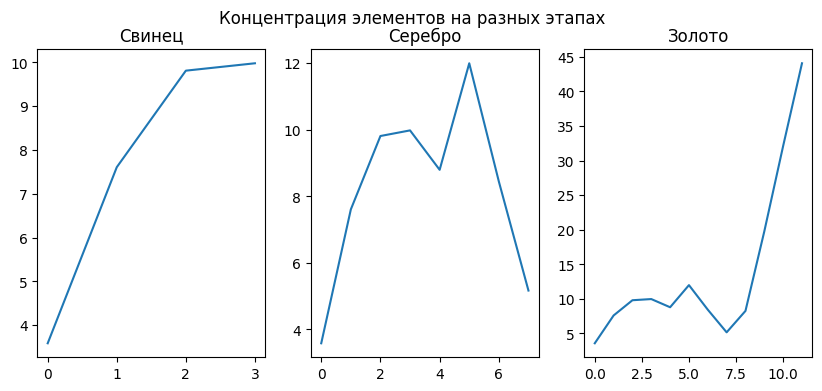

In [18]:
list_of_elements = ['Свинец', 'Серебро', 'Золото']
list_of_stage = [
    'До флотации:',
    'После флотации:',
    'После первичной очистки:',
    'После вторичной очистки:'
]
list_of_mean = []

fig,axs = plt.subplots(1,3, figsize=(10,4))
fig.suptitle('Концентрация элементов на разных этапах')

for num, col in enumerate(concentration):
    print()
    print(list_of_elements[num])
    print('-'*25)
    print('Концентрация')

    
    for n, stage in enumerate (col):
        print()
        print(list_of_stage[n])
        print(col[stage].mean())
        list_of_mean.append(col[stage].mean())
        
    axs[num].plot(list_of_mean)
    axs[num].set_title(list_of_elements[num])
plt.show()

Можно заметить что в процессе обработки руды:  
- Концентрация свинца увеличивается,  
- Коцентрация золота значительно увеличивается на каждом этапе, (хотя график показывает на первых этапах нелинейную зависимость) 
- Концентрация серебра сначала повышается, затем снижается

### Распределения размеров гранул на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [19]:
# Внесем в список размеры гранул из обучающей тестовой выборок

granule_size = [
    df_train['rougher.input.feed_size'],
    df_test['rougher.input.feed_size']
]

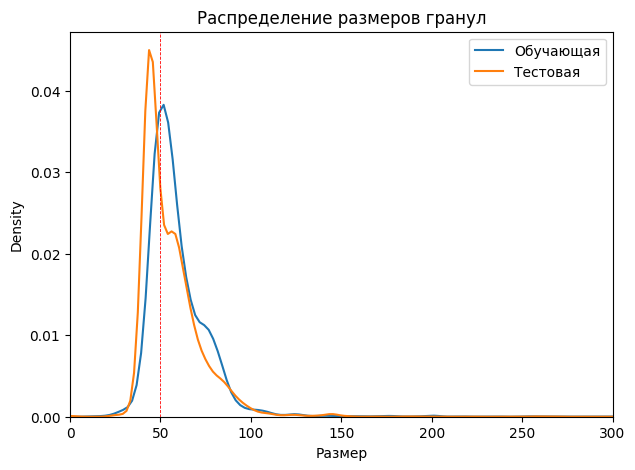

In [20]:
fig,ax = plt.subplots(figsize=(7,5))
titl = ['Обучающая', 'Тестовая']
for col in granule_size:
    sns.kdeplot(col)
    ax.set_xlim(0,300)
    ax.set_title('Распределение размеров гранул')
    plt.xlabel('Размер')
    plt.legend(titl)
plt.axvline(50, c='r', lw=0.6, ls='--')

Графики схожи между собой, но есть смещения по значениям.  
Видим, что пиковое значение распределения размера гранул в тестовой выборке сосредоточено до 50, в обучающей около 50.  
Также есть значения, которые указывают на несвойственно большие значения размеров гранул, таких значений немного, но они есть, Это похоже на выбросы. Исследуем это подробнее

Построим диаграммы размаха, чтобы посмотреть на выбросы

 Обучающая выборка: 99% значений в диапазоне от 23 до 91
 Тестовая выборка: 99% значений в диапазоне от 16 до 90


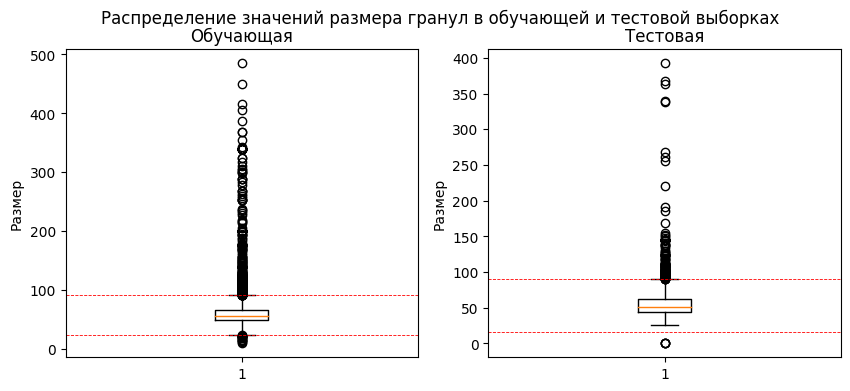

In [21]:
# boxplot для исследования выбросов в распределении значений размера гранул

fig,axs = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Распределение значений размера гранул в обучающей и тестовой выборках')

for num, col in enumerate (granule_size):
    
    axs[num].boxplot(
        data=col,
        x = col.values
    )
    axs[num].set_ylabel('Размер')
    axs[num].set_title(titl[num])
    
# Границы выбросов:

    high_quantile = col.quantile(0.75)
    low_quantile = col.quantile(0.25)
    iqr = high_quantile - low_quantile
    
    high_treshold = high_quantile + 1.5*iqr
    low_treshold = low_quantile - 1.5*iqr
    axs[num].axhline(high_treshold, c='r', lw=0.6, ls='--')
    axs[num].axhline(low_treshold, c='r', lw=0.6, ls='--')
    print(f' {titl[num]} выборка: 99% значений в диапазоне от {int(low_treshold)} до {int(high_treshold)}')
plt.show()

На этом графике видим что выбросы - значения размера гранул до 16 и превышающие значение 90

#### Обработка выбросов

In [22]:
# Удалим выбросы и перезапишем выборки

list_col_size = []
for num, col in enumerate (granule_size):
    high_quantile = col.quantile(0.75)
    low_quantile = col.quantile(0.25)
    iqr = high_quantile - low_quantile
    
    high_treshold = high_quantile + (1.5*iqr)
    low_treshold = low_quantile - (1.5*iqr)
    
    col = col[(col>low_treshold)&(col<high_treshold)]
    list_col_size.append(col)

# Перезапишем столбцы (без выбросов)
df_train['rougher.input.feed_size'] = list_col_size[0]
df_test['rougher.input.feed_size'] = list_col_size[1]

# Удалим образовавшиеся пропуски в выборках
df_train = df_train.dropna(subset = 'rougher.input.feed_size', axis=0)
df_test = df_test.dropna(subset = 'rougher.input.feed_size', axis=0)

### Суммарная концентрация

Исследуем суммарную концентрацию всех веществ на разных стадиях: (По условиям задания) - в сырье, в черновом и финальном концентратах.

In [23]:
# Подготовим данные для исследования суммарной концентрации

stages = [
    
    df_train
    [['rougher.input.feed_pb',
      'rougher.input.feed_ag',
      'rougher.input.feed_au',
      'rougher.input.feed_sol']],
    
    df_train
    [['rougher.output.concentrate_pb',
      'rougher.output.concentrate_ag',
      'rougher.output.concentrate_au',
      'rougher.output.concentrate_sol']],
    
    df_train
    [['final.output.concentrate_pb',
      'final.output.concentrate_ag',
      'final.output.concentrate_au',
      'final.output.concentrate_sol']]
]

list_stages = ['input', 'rougher', 'final']
list_of_stages = ['В Сырье', 'В Черновом концентрате', 'В Финальном концентрате']


In [24]:
# Вычислим сумманрную концентрацию

list_sum_concentration = []
for n, stage in enumerate(stages):
    stage['summary'] = stage.sum(axis=1)
    list_sum_concentration.append(stage['summary'])
    display(stage.head(3))

/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/1916840920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage['summary'] = stage.sum(axis=1)


,rougher.input.feed_pb,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_sol,summary
0,2.284912,6.100378,6.486150,36.808594,51.680034
1,2.266033,6.161113,6.478583,35.753385,50.659114
2,2.159622,6.116455,6.362222,35.971630,50.609929


/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/1916840920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage['summary'] = stage.sum(axis=1)


,rougher.output.concentrate_pb,rougher.output.concentrate_ag,rougher.output.concentrate_au,rougher.output.concentrate_sol,summary
0,7.101074,11.500771,19.793808,28.029297,66.424950
1,7.278807,11.615865,20.050975,28.067063,67.012710
2,7.216833,11.695753,19.737170,27.454037,66.103793


/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/1916840920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage['summary'] = stage.sum(axis=1)


,final.output.concentrate_pb,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_sol,summary
0,9.889648,6.055403,42.192020,5.507324,63.644396
1,9.968944,6.029369,42.701629,5.257781,63.957723
2,10.213995,6.055926,42.657501,5.383759,64.311180


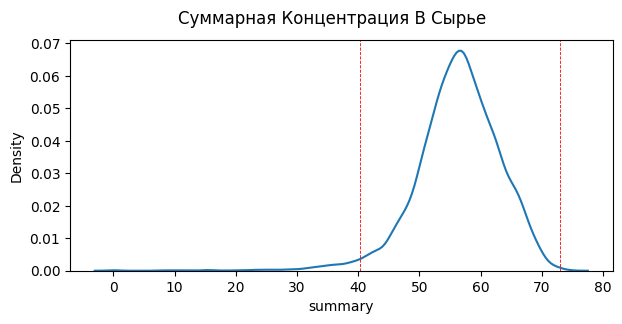

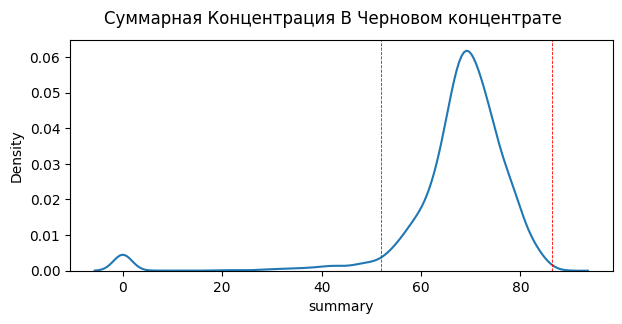

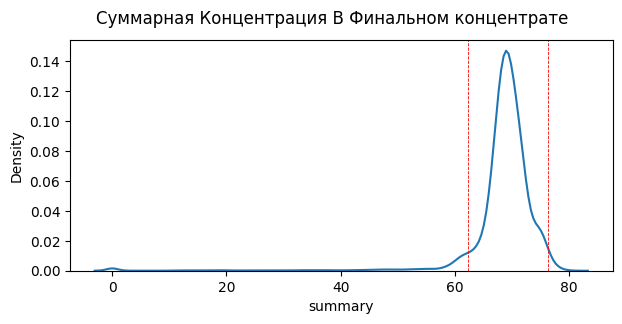

In [25]:
# Посмотрим на графиках распределение и возможные выбросы
    
for n, array in enumerate (list_sum_concentration):
    fig,ax = plt.subplots(figsize=(7,3))
    fig.suptitle(f'Суммарная Концентрация {list_of_stages[n]}')
    sns.kdeplot(array)
    
    # Проверим выбросы в распределении:
    
    high_quantile = array.quantile(0.75)
    low_quantile = array.quantile(0.25)
    iqr = high_quantile - low_quantile
    
    high_treshold = high_quantile + 1.5*iqr
    low_treshold = low_quantile - 1.5*iqr
    
    
    plt.axvline(high_treshold, c='r', lw=0.6, ls='--')
    plt.axvline(low_treshold, c='r', lw=0.6, ls='--')

- Судя по графикам плотность распределения значений суммарной концентрации увеличивается на каждом этапе обработки.  
- Также видим выбросы. Увеличенное количество выбросов в черновом и финальном концентрате присутствует около значения 0. Больше всего выбросов в значениях суммарной концентрации финального концентрата

In [26]:
# Удалим выбросы

for n, array in enumerate (list_sum_concentration):
    high_quantile = array.quantile(0.75)
    low_quantile = array.quantile(0.25)
    iqr = high_quantile - low_quantile
    
    high_treshold = high_quantile + 1.5*iqr
    low_treshold = low_quantile - 1.5*iqr
    
    array = pd.Series(array[(array>low_treshold)&(array<high_treshold)])
    list_sum_concentration[n] = array

In [27]:
# Создадим новые столбцы с рассчетом суммарной концентрации элементов

df_train['input.sum_con'] = list_sum_concentration[0]
df_train['rougher.sum_con'] = list_sum_concentration[1]
df_train['final.sum_con'] = list_sum_concentration[2]

/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/970518543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['input.sum_con'] = list_sum_concentration[0]
/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/970518543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rougher.sum_con'] = list_sum_concentration[1]
/var/folders/8l/pbs9j79s2x537_ttxmbz8y5r0000gn/T/ipykernel_50650/970518543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [28]:
# Удалим строки в которых образовались пропуски (После исключения выбросов)

df_train = df_train.dropna(subset = ['input.sum_con', 'rougher.sum_con', 'final.sum_con'], axis = 0)

In [29]:
# Удалим столбцы с рассчитанной суммарной концентрацией элементов (Это больше не понадобится)

df_train = df_train.drop(['input.sum_con', 'rougher.sum_con', 'final.sum_con'], axis = 1)

### Подготовка данных к обучению

In [30]:
# Выделим признаки и целевые признаки в обучающей выборке

rougher_columns = [c for c in df_test.columns if "rougher" in c and c != 'rougher.output.recovery']
features_train_rougher = df_train[rougher_columns]
target_train_rougher = df_train['rougher.output.recovery']

 
features_train_final = df_train[df_test.columns]
features_train_final = features_train_final.drop(['final.output.recovery','date'], axis=1)
target_train_final = df_train['final.output.recovery']

In [31]:
target_name_list = ['target_rougher', 'target_final']

In [32]:
# Выделим признаки и целевые признаки в тестовой выборке

features_test_rougher = df_test[rougher_columns]
target_test_rougher = df_test['rougher.output.recovery']

features_test_final = df_test.drop(['final.output.recovery','date'], axis=1)
target_test_final = df_test['final.output.recovery']

In [33]:
features_train_list = [features_train_rougher, features_train_final]
features_test_list = [features_test_rougher, features_test_final]

#### Масштабирование

In [34]:
# Будем использовать MinMaxScaler - один масштаб (от 0 - 1))

scaler = MinMaxScaler()

In [35]:
# Масштабирование обучающих признаков

features_train_scaled = []
for n, frame in enumerate(features_train_list):
    frame = pd.DataFrame(scaler.fit_transform(frame), columns = frame.columns)
    features_train_scaled.append(frame)

In [36]:
# Перезапишем масштабированные признаки

features_train_rougher = features_train_scaled[0]
features_train_final = features_train_scaled[1]

In [37]:
# Масштабирование тестовых признаков

features_test_scaled = []
for n, frame in enumerate(features_test_list):
    frame = pd.DataFrame(scaler.fit_transform(frame), columns = frame.columns)
    features_test_scaled.append(frame)

In [38]:
features_test_rougher = features_test_scaled[0]
features_test_final = features_test_scaled[1]

In [39]:
# Поместим признаки в списки

features_train_list = [features_train_rougher, features_train_final]
target_train_list = [target_train_rougher, target_train_final]

In [40]:
features_test_list = [features_test_rougher, features_test_final]
target_test_list = [target_test_rougher, target_test_final]

**Анализ Данных** показал:  
- **Концентрация металллов** меняется на каждом этапе обработки  
Концентрация свинца увеличивается, золота значительно увеличивается на каждом этапе,
Концентрация серебра сначала повышается, затем снижается

- **Распределение размеров гранул** и **Суммарная концентрация** выступают в роли метрик, с помощью которых усредняют общее значение  концентрации по элементам и по размеру гранул , таким образом можно почистить данные от выбросов.

---

## Модель

### Функция для вычисления итоговой sMAPE.



По условиям проекта Метрика качества sMAPE вычисляется по формуле:

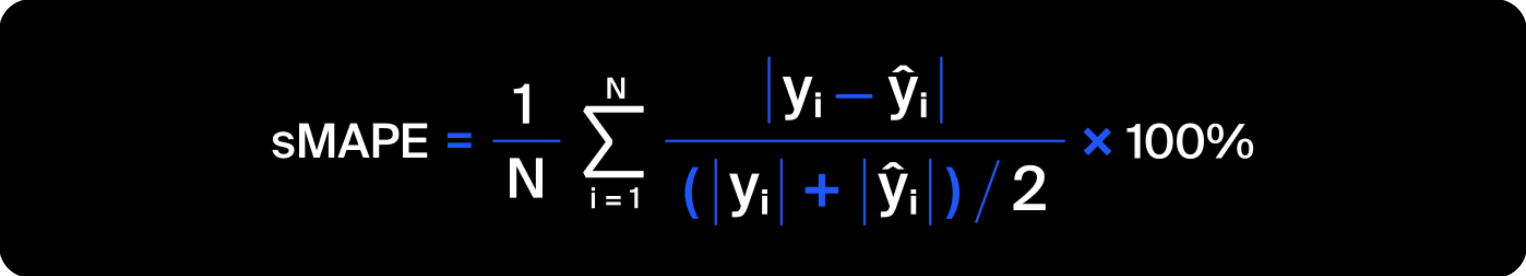

In [41]:
def sMAPE(target, pred):
    smape = np.mean(abs(target - pred) / ((abs(target) + abs(pred))/2)) * 100
    return smape

Итоговое sMAPE по формуле:

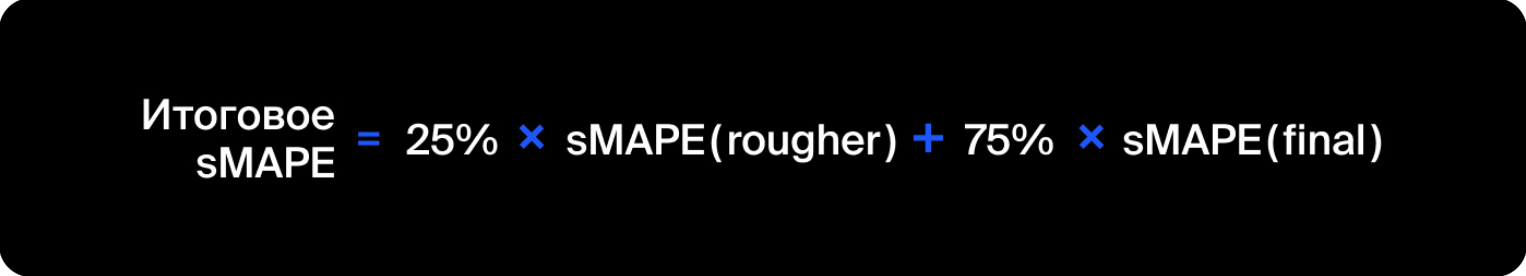

In [42]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)


In [43]:
# Создадим метрику для кроссвалидации

smape_score = make_scorer(sMAPE, greater_is_better=False)

### Построение разных моделей и оценка их качества кросс-валидацией.   

In [44]:
# Поместим гиперпараметры в словари для дальнейшего подбора

model_tree = DecisionTreeRegressor(random_state = RANDOM)
params_tree = {
    'max_depth': range(1,20)
}

model_forest = RandomForestRegressor(random_state = RANDOM)
params_forest = {
    'n_estimators': range(2, 100),
    'max_depth': range(1, 20),
    'max_features': ['log2', 'sqrt', None],
    'bootstrap': [True, False]
}
model_regression = LinearRegression()
params_regression = {
    'copy_X': True,
    'fit_intercept': True,
    'positive': False
}
model_cat = CatBoostRegressor()
params_catboost = {
    'iterations': range(1,100),
    'depth': range(1, 20),
    'verbose': [False]
}


In [45]:
# Поиск параметров для DecisionTreeRegressor

rs_tree_list = []
for n, feat in enumerate(features_train_list):
    rs_tree = RandomizedSearchCV(model_tree, params_tree, scoring = smape_score, random_state=RANDOM)
    rs_tree.fit(feat, target_train_list[n])
    rs_tree_list.append(rs_tree)

In [46]:
# Лучшие гиперпараметры для DecisionTreeRegressor

rs_tree_rougher = rs_tree_list[0]
rs_tree_final = rs_tree_list[1]
rs_tree_rougher_params = rs_tree_rougher.best_params_
rs_tree_final_params = rs_tree_final.best_params_

print(f'Лучшие параметры rs_tree_rougher: {rs_tree_rougher_params}')
print(f'Лучшие параметры rs_tree_final: {rs_tree_final_params}')

Лучшие параметры rs_tree_rougher: {'max_depth': 4}
Лучшие параметры rs_tree_final: {'max_depth': 4}


In [47]:
rs_tree_best_params = {
    'max_depth': [4]
}

Код в следующей ячейке Закоментирован - занимает много времени(CPU times: user 8min 10s) Лучшие параметры поолучены.

In [48]:
#%%time
## Поиск параметров для RandomForestRegressor
#
#rs_forest_list = []
#for n, feat in enumerate(features_train_list):
#    rs_forest = RandomizedSearchCV(model_forest, params_forest, scoring = smape_score, random_state=RANDOM)
#    rs_forest.fit(feat,target_train_list[n])
#    rs_forest_list.append(rs_forest)

In [49]:
# Лучшие гиперпараметры для RandomForestRegressor

rs_forest_rougher_params = {
    'n_estimators': [38],
    'max_features': ['log2'],
    'max_depth': [5],
    'bootstrap': [False]
}

rs_forest_final_params = {
    'n_estimators': [58],
    'max_features': [None],
    'max_depth': [2],
    'bootstrap': [True]
}

rs_forest_best_params = [rs_forest_rougher_params, rs_forest_final_params]

In [50]:
rs_regression_best_params = {
    'copy_X': [True],
    'fit_intercept': [True],
    'positive': [False]
}


<div class="alert alert-info">
    <b>Комментарий:</b>
    Запущу Catboost.  
    КОд закоментирован - долго выполнялся - найдены лучшие гиперпараметры(некоторые)

In [51]:
#%%time
#rs_cat_list = []
#for n, feat in enumerate(features_train_list):
#    rs_cat = RandomizedSearchCV(model_cat, params_catboost, scoring = smape_score, random_state=RANDOM)
#    rs_cat.fit(feat, target_train_list[n])
#    rs_cat_list.append(rs_cat)

In [52]:
rs_cat_rougher_params = {
    'verbose': [True],
    'iterations': [93],
    'depth': [2]
}
rs_cat_final_params = {
    'verbose': [False],
    'iterations': [99],
    'depth': [11]}
rs_cat_best_params = [rs_cat_rougher_params, rs_cat_final_params]

### Лучшая модель.  Проверка лучшей модели на тестовой выборке

#### Лучшая модель

Лучшую модель будем искать с помощью GridSearchCV

In [53]:
target_rougher_sMAPE = []
target_final_sSMAPE = []
target_score = [target_rougher_sMAPE, target_final_sSMAPE]

In [54]:
# DecisionTree
grid_tree_models = []
for n, feat in enumerate(features_train_list):
    print(f'{target_name_list[n]}:')
    grid_tree = GridSearchCV(model_tree, rs_tree_best_params, scoring = smape_score)
    grid_tree.fit(feat,target_train_list[n])
    grid_tree_models.append(grid_tree)
    target_score[n].append(grid_tree.best_score_)
    print(f'sMAPE: {grid_tree.best_score_}')
    

target_rougher:
sMAPE: -6.852234629865104
target_final:
sMAPE: -7.959179940157895


In [55]:
# RandomForest

grid_forest_models = []
for n, feat in enumerate(features_train_list):
    print(f'{target_name_list[n]}:')
    grid_forest = GridSearchCV(model_forest, rs_forest_best_params[n], scoring = smape_score)
    grid_forest.fit(feat,target_train_list[n])
    grid_forest_models.append(grid_forest)
    target_score[n].append(grid_forest.best_score_)
    print(f'sMAPE: {grid_forest.best_score_}')

target_rougher:
sMAPE: -5.937351080907061
target_final:
sMAPE: -7.247242620807834


In [56]:
# LinearRegression

grid_regression_models = []
for n, feat in enumerate(features_train_list):
    print(f'{target_name_list[n]}:')
    grid_regression = GridSearchCV(model_regression, rs_regression_best_params, scoring = smape_score)
    grid_regression.fit(feat,target_train_list[n])
    grid_regression_models.append(grid_regression)
    target_score[n].append(grid_regression.best_score_)
    print(f'sMAPE: {grid_regression.best_score_}')

target_rougher:
sMAPE: -6.1923158911319
target_final:
sMAPE: -7.687343156379518


In [57]:
# CatBoostRegressor

grid_cat_models = []
for n, feat in enumerate(features_train_list):
    print(f'{target_name_list[n]}:')
    grid_cat = GridSearchCV(model_cat, rs_cat_best_params, scoring = smape_score)
    grid_cat.fit(feat,target_train_list[n], verbose=False)
    grid_cat_models.append(grid_cat)
    target_score[n].append(grid_cat.best_score_)
    print(f'sMAPE: {grid_cat.best_score_}')

target_rougher:
sMAPE: -6.0600589431152265
target_final:
sMAPE: -7.657351472651378


In [58]:
name_models_list = ['DecisionTree', 'RandomForest', 'LinearRegression', 'CatBoostRegressor']

In [59]:
# Найдем для каждого целевого признака лучшую модель

best_model_score = []

for n, st in enumerate(target_score):
    best_score = 100
    print()
    print(f'{target_name_list[n]}:')
    
    for num, score in enumerate (st):
        if abs(score) < best_score:
            best_score = abs(score)
            best_model = name_models_list[num]
    best_model_score.append(-best_score)        
    print(f'Лучшая модель:{best_model}, sMAPE: {-best_score}')


target_rougher:
Лучшая модель:RandomForest, sMAPE: -5.937351080907061

target_final:
Лучшая модель:RandomForest, sMAPE: -7.247242620807834


Лучшие показатели sMAPE для обоих целевых признаков у RandomForest, будем использовать эту модель для проверки на тестовой выборке и рассчета итогового sMAPE

In [60]:
# Итоговое sMAPE

final_sMAPE(best_model_score[0],best_model_score[1])

-6.919769735832641

#### Проверка лучшей модели на тестовой выборке

In [61]:
# Запустим лучшие модели

test_pred_list = []
for n, model in enumerate(grid_forest_models):
    predictions = model.predict(features_test_list[n])
    test_pred_list.append(predictions)

In [62]:
# Рассчет sMAPE лучшей модели на тестовой выборке

test_smape_list = []
for n, pred in enumerate(test_pred_list):
    test_smape = sMAPE(target_test_list[n], pred)
    test_smape_list.append(test_smape)

In [63]:
# Итоговое sMAPE лучшей модели на тестовой выборке

print(f'Итоговое sMAPE лучшей модели на тестовой выборке: {final_sMAPE(test_smape_list[0],test_smape_list[1])}')

Итоговое sMAPE лучшей модели на тестовой выборке: 8.166713006774442


### Константная модель 

In [64]:
dummy_model = DummyRegressor()

In [65]:
# Запустим DummyRegressor

dummy_predictions_list = []
for n, feat in enumerate(features_train_list):
    dummy_model.fit(feat, target_train_list[n])
    dummy_predictions = dummy_model.predict(features_test_list[n])
    dummy_predictions_list.append(dummy_predictions)

In [66]:
# sMAPE Dummy

dummy_smape_list = []
for n, pred in enumerate(dummy_predictions_list):
    dummy_smape = sMAPE(target_test_list[n], pred)
    dummy_smape_list.append(dummy_smape)

In [67]:
# Итоговое sMAPE Dummy модели на тестовой выборке

print(f'Итоговое sMAPE Dummy модели на тестовой выборке: {final_sMAPE(dummy_smape_list[0],dummy_smape_list[1])}')

Итоговое sMAPE Dummy модели на тестовой выборке: 9.510239190663594


**RandomForest** - лучшая модель! Итоговое sMAPE на обучающей выборке ниже чем в остальных моделях! На тестовой выборке Итоговое sMAPE гораздо ниже чем в константной модели

## Вывод по проекту

<div style="border:solid gray 2px; padding: 20px">  

В Этом проекте по условиям заданий выполнено:  
- **Подготовка данных.**  
    На данном этапе изучили выборки (полную, обучающую и тестовую), сравнили наличие и отсутствие признаков в каждой из них, подготовили данные к обучению.  
- **Анализ Данных.**  
    Изучили такие показатели как Размер гранул сырья, как менялась концентрация элементов на каждом этапе обработки.  (Концентрация золота увеличивается на каждом этапе обработки), также почистили данные от выбросов!  
- **Построение моделей**. 
    Построили несколько моделей, лучшей для обоих целевых признаков оказалась модель **RandomForest**.  
    Итоговое sMAPE на обучающей выборке 6.919769735832641  
    Итоговое sMAPE на тестовой выборке 8.166713006774442

---